In [1]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import os

import tensorflow as tf
import json
import time

import gymnasium as gym

## Implementing Q-Learning

In [2]:
class CartPoleAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.v_values = defaultdict(lambda: np.zeros(1))

        self.N_q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.N_v = defaultdict(lambda: np.zeros(1))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs, policy) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """        
        action_probs = policy[obs]
        action = np.random.choice(len(action_probs), p=action_probs)
        
        return action

    def update(
        self,
        obs: tuple[int, int, int, int],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, int, int],
        next_action: int,
    ):
        """Updates the Q-value of an action."""
        # print("b",obs)
        # print("c",next_obs)
        future_q_value = (not terminated) * self.q_values[next_obs][next_action]
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    # def save_model(self, path, filename):
    #     q_values_np = np.array(self.q_values)

    #     # Save model parameters to a JSON file
    #     model_params = {
    #         'q_values': q_values_np.tolist(),
    #         # 'biases': self.biases.tolist()
    #     }
    #     full_path = os.path.join(path, filename)
    #     with open(full_path, 'w') as f:
    #         json.dump(model_params, f)

    def save_model(self, path, filename):
        # Convert tuple keys to strings
        q_values_str_keys = {str(k): v.tolist() for k, v in self.q_values.items()}
        
        # Save model parameters to a JSON file
        model_params = {
            'q_values': q_values_str_keys,
            # 'biases': self.biases.tolist()
        }
        full_path = os.path.join(path, filename)
        with open(full_path, 'w') as f:
            json.dump(model_params, f)

            
    def load_model(self, path, filename):
        full_path = os.path.join(path, filename)
        with open(full_path, 'r') as file:
            data = json.load(file)
            data_q_values = data['q_values']
            for state, action_values in data_q_values.items():
                self.q_values[state] = action_values.copy()
            return self.q_values



In [3]:
def map_discrete_state(cs):
    cs[0] = int(cs[0] * 10)
    cs[1] = int(cs[1] * 10)
    cs[2] = int(cs[2] * 10)
    cs[3] = int(cs[3] * 10)
    
    ds = tuple(cs)
    return ds

### Reward Function

In [4]:
def reward_function(ds, ds_prev, stable_term, t, terminated):
    angle_threshold =  0.05

    # Term 1: นิ่ง
    delta_angle = abs(ds[0] - ds_prev[0]) 
    stable_term += delta_angle 

    # Term 2: ตั้งตรง
    if ds[0] < angle_threshold:
        swing_up_term = 0
    else:
        swing_up_term = abs(ds[0])

    # Term 3 Avoid early termination
    if terminated:
        termination_term = -10000
    else:
        termination_term = 0

    error_pole_pos = 0 - abs(ds[2])
    
    reward = t * (stable_term + swing_up_term) + termination_term

    return reward, stable_term

In [9]:
environment_name = 'CartPole-v1'
# env = gym.make(environment_name, render_mode="human")
env = gym.make(environment_name)

In [10]:
# hyperparameters
learning_rate = 0.01
n_episodes = 500000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.01

discount = 1

agent = CartPoleAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [11]:
path = os.path.join('Training', 'Save Models')
agent.load_model(path, "GLIE MC 300000.json")

defaultdict(<function __main__.CartPoleAgent.__init__.<locals>.<lambda>()>,
            {'(-10.0, -40.0, 10.0, 70.0)': [1380.0, 0.0],
             '(-10.0, -20.0, 10.0, 40.0)': [2453.0, 0.0],
             '(-10.0, -40.0, 10.0, 60.0)': [173335.2, 3237.0],
             '(-10.0, -20.0, 10.0, 30.0)': [207885.0, 0.0],
             '(-10.0, -40.0, 10.0, 50.0)': [0.0, 14669.25],
             '(0.0, -20.0, 10.0, 20.0)': [4035.0, 0.0],
             '(0.0, -40.0, 10.0, 50.0)': [0.0, 4035.0],
             '(0.0, -60.0, 10.0, 70.0)': [0.0, 4035.0],
             '(0.0, -80.0, 0.0, 100.0)': [1809.0, 150284.8],
             '(0.0, -90.0, 0.0, 130.0)': [0.0, 4035.0],
             '(0.0, -80.0, 0.0, 90.0)': [4035.0, 4035.0],
             '(0.0, -60.0, 0.0, 60.0)': [4035.0, 391630.79412518675],
             '(0.0, -60.0, 0.0, 70.0)': [4035.0, 0.0],
             '(0.0, -40.0, 0.0, 40.0)': [4035.0, 0.0],
             '(0.0, -20.0, 0.0, 20.0)': [997574.5555555555, 0.0],
             '(0.0, 0.0, 0.0, 0.0)':

In [12]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

dis_play_list =[]

N = defaultdict(lambda: np.zeros(env.action_space.n))
return_sum = defaultdict(lambda: np.zeros(env.action_space.n))

policy = defaultdict(lambda: np.full(env.action_space.n, 0.5))

epsilon_greedy = 0


for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    score = 0
    discrete_state = (0, 0, 0, 0)
    discrete_reward = 0
    new_discrete_state = [0, 0, 0, 0]
    iteration = 0

    prev_time = 0

    targetAngle = 0

    history_ls = []

    stable_term = 0
    t = 0

    # play one episode
    while not done:
        env.render()
        # Choose a from s using policy derived from Q
        discrete_state = map_discrete_state(obs)
        action = agent.get_action(discrete_state, policy)

        obs, reward, terminated, truncated, info = env.step(action)

        new_discrete_state = map_discrete_state(obs)
        score += reward

        present_time = time.time()
        delta_time = present_time - prev_time
        prev_time = present_time

        discrete_reward, stable_term = reward_function(new_discrete_state, discrete_state, stable_term, t, terminated)
        t += 1

        history_ls.append([discrete_state, action, discrete_reward])

        # Choose next a from next s using policy derived from Q
        # new_action = agent.get_action(new_discrete_state, policy)

        # update the agent
        # agent.update(discrete_state, action, reward, terminated, new_discrete_state, new_action)
        

        # update if the environment is done and the current obs
        done = terminated or truncated
        # print("terminated: ", terminated, "truncated", truncated)
        # if done == True:
        #     print("reward: ", discrete_reward)
        # obs = next_obs
    
    G = 0
    St = 0
    At = 0
    for i in reversed(range(len(history_ls)-1)):
        St = history_ls[i][0]
        At = history_ls[i][1]
        G = discount*G + history_ls[i][2]

        # Update state value function
        # agent.N_v[St] += 1
        # agent.v_values[St] = agent.v_values[St] + (G - agent.v_values[St])/agent.N[St]

        # Update state-action value function
        agent.N_q[St][At] += 1
        agent.q_values[St][At] = agent.q_values[St][At] + (G - agent.q_values[St][At])/agent.N_q[St][At]
        
        epsilon_greedy = 1/(episode+1)

        if np.random.random() < epsilon_greedy:
            policy[St][0] = 0.5
            policy[St][1] = 0.5

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            for i in range(len(policy[St])):
                if i == np.argmax(agent.q_values[St]):
                    policy[St][i] = 1
                else:
                    policy[St][i] = 0



    dis_play_list.append(score)

    agent.decay_epsilon()

  0%|          | 0/500000 [00:00<?, ?it/s]

d:\anacoda3\envs\RL-env\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(
  1%|          | 2889/500000 [00:13<38:49, 213.41it/s]


KeyboardInterrupt: 

In [ ]:
history_ls

[[(0.0, 0.0, 0.0, 0.0), 1, (0.0, 0.0)],
 [(0.0, 10.0, 0.0, -20.0), 0, (0.0, 0.0)],
 [(0.0, 0.0, 0.0, 0.0), 1, (0.0, 0.0)],
 [(0.0, 10.0, 0.0, -20.0), 1, (0.0, 0.0)],
 [(0.0, 30.0, 0.0, -50.0), 1, (0.0, 0.0)],
 [(0.0, 50.0, 0.0, -80.0), 1, (0.0, 0.0)],
 [(0.0, 70.0, 0.0, -110.0), 1, (0.0, 0.0)],
 [(0.0, 90.0, 0.0, -140.0), 0, (0.0, 0.0)],
 [(0.0, 70.0, 0.0, -110.0), 1, (0.0, 0.0)],
 [(0.0, 90.0, 0.0, -140.0), 1, (0.0, 0.0)],
 [(0.0, 110.0, -10.0, -170.0), 1, (20.0, 1.0)],
 [(10.0, 130.0, -10.0, -200.0), 0, (110.0, 9.0)],
 [(10.0, 110.0, -10.0, -180.0), 0, (120.0, 9.0)]]

In [ ]:
env.close()

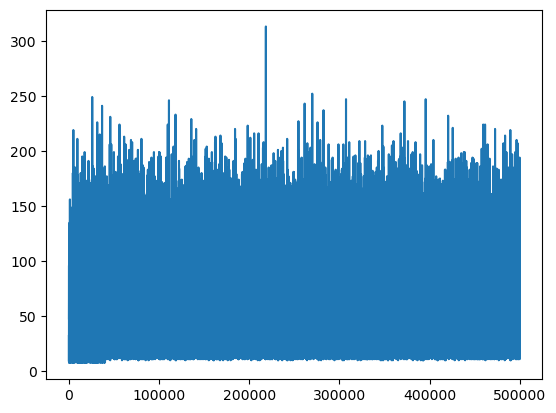

In [ ]:
display_np = np.array(dis_play_list)

t = np.linspace(1, len(display_np), len(display_np))

plt.plot(t, display_np)
plt.show() 

In [ ]:
path = os.path.join('Training', 'Save Models')
agent.save_model(path, 'GLIE MC 500000.json')